<a href="https://colab.research.google.com/github/brunoras/nlpjuridico/blob/main/Analise_de_Dados_TJBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importações, Funções e Inicializações

In [ ]:
# Visualização:
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utilitários:
from string import punctuation
import numpy as np
import re

# Processamento de Linguagem Natural:
import nltk
from nltk.tokenize import word_tokenize
from nltk import tokenize
from nltk.stem import SnowballStemmer
import gensim
import spacy
from spacy import displacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!unzip lener-br_brunoras.zip

Archive:  lener-br_brunoras.zip
  inflating: tjba_casos_estupro.txt  
  inflating: tjba_casos_droga.txt    
   creating: lener-br_brunoras/
   creating: lener-br_brunoras/vocab/
  inflating: lener-br_brunoras/vocab/strings.json  
 extracting: lener-br_brunoras/vocab/key2row  
  inflating: lener-br_brunoras/vocab/vectors  
 extracting: lener-br_brunoras/vocab/vectors.cfg  
 extracting: lener-br_brunoras/vocab/lookups.bin  
   creating: lener-br_brunoras/tok2vec/
 extracting: lener-br_brunoras/tok2vec/cfg  
  inflating: lener-br_brunoras/tok2vec/model  
  inflating: lener-br_brunoras/tokenizer  
  inflating: lener-br_brunoras/meta.json  
   creating: lener-br_brunoras/ner/
  inflating: lener-br_brunoras/ner/cfg  
  inflating: lener-br_brunoras/ner/model  
  inflating: lener-br_brunoras/ner/moves  
  inflating: lener-br_brunoras/config.cfg  
   creating: workdir/


In [ ]:
def grafs(nuvem, k):
   # Observando se o doc é uma lista ou string:
   if type(nuvem) == str:
      fusao_nuvem = nuvem
   else:
      fusao_nuvem = ' '.join([texto for texto in nuvem])

   # Gerando a nuvem de palavras:
   cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(fusao_nuvem)

   # Plotando uma imagem da nuvem de palavras:
   plt.figure(figsize=(10,7))
   plt.imshow(cloud, interpolation = 'bilinear')
   plt.axis('off')
   plt.show()

   # Distribuição de frequências:
   token_espaco = tokenize.WhitespaceTokenizer()
   freq = nltk.FreqDist(token_espaco.tokenize(fusao_nuvem))
   df_freq = pd.DataFrame({'Palavra': list(freq.keys()), 'Frequência': list(freq.values())})

   # Plotando um gráfico de barras horizontais das frequênicas:
   df_bar = df_freq.nlargest(columns = 'Frequência', n = k)
   plt.figure(figsize = (12,8))
   ax = sns.barplot(data = df_bar, x = 'Frequência', y = 'Palavra', color = 'blue')
   ax.set(xlabel = 'Frequência')
   plt.show()

In [ ]:
def tokenizar(doc):
    # Tokenização:
    stems = []
    for caso in doc:  
      # Deixando tudo minúsculo:
      processed_caso = caso.lower()
    
      # Removendo caracteres especiais:
      processed_caso = re.sub(r'[^a-záàâãéèêíïóôõöúçñ]', ' ', processed_caso)
    
      # Removendo caracteres isolados:
      processed_caso = re.sub(r'\s+[a-z]\s+', ' ', processed_caso)
      processed_caso = re.sub(r'^[a-z]\s+', ' ', processed_caso) # Letra no início.
      processed_caso = re.sub(r'\s+[a-z]$', ' ', processed_caso) # Letra no fim.
      processed_caso = re.sub(r'\s+[a-z]\s+', ' ', processed_caso) # De novo para tirar casos "letra, espaço, letra".
    
      # Substituindo múltiplos espaços por um único espaço:
      processed_caso = re.sub(r'\s+', ' ', processed_caso)
    
      # Removendo espaços no início e no fim:
      processed_caso = re.sub(r'^\s+', '', processed_caso)
      processed_caso = re.sub(r'\s+$', '', processed_caso)
    
      # Removendo stopwords e extraindo o radical das palavras:
      list_stem = []
      token = tokenize.WhitespaceTokenizer()
      words = token.tokenize(processed_caso)
      filtered_tokens = [stemmer.stem(palavra) for palavra in words if palavra not in stopwords]
      list_stem.append(' '.join(filtered_tokens))
      stems.append(list_stem[0])
    
    return stems

In [ ]:
def comparar(casos_docs, meucaso):
    # Separando os tokens em cada documento
    gen_docs = [word_tokenize(text) for text in casos_docs]
    
    # Criando o dicionário
    dictionary = gensim.corpora.Dictionary(gen_docs)
    
    # Criando o corpus
    corpus = [dictionary.doc2bow(doc) for doc in gen_docs]
    
    # TF-IDF
    tf_idf = gensim.models.TfidfModel(corpus)
    
    # Construindo o Index
    sims = gensim.similarities.Similarity('workdir/', tf_idf[corpus], num_features=len(dictionary))
    
    # Tokenizando o documento para comparação
    query_doc = word_tokenize(meucaso)
    
    # Dando update no dicionário
    query_doc_bow = dictionary.doc2bow(query_doc)
    
    # Comparando com o corpus
    query_doc_tf_idf = tf_idf[query_doc_bow]
    
    # Gerando resultado
    result = sims[query_doc_tf_idf]
    df_result = pd.DataFrame()
    df_result['semelhanca'] = result
    return df_result.sort_values(by=['semelhanca'], ascending=False)

In [ ]:
def tagtexto(dataset, sim, simk, n):
  # Reconhecimento de Entidade Nomeada
  textoner = NER(dataset.texto[n])
  
  # Cores dos tags
  colors = {'ORGANIZACAO': '#00FFFF', 'PESSOA': '#0000FF', 'TEMPO': '#0BDA51',
            'LOCAL': '#FF00FF', 'LEGISLACAO': '#7F00FF', 'JURISPRUDENCIA': '#E4D00A'}
  options = {"colors": colors}
  
  # Verbose
  print(f'{round(sim.semelhanca[n]*100, 2)}% de semelhança sem tokenizar.')
  print(f'{round(simk.semelhanca[n]*100, 2)}% de semelhança tokenizando.')
  print('')
  print(f"[{dataset.classe[n]}]")
  
  # Tageando
  print('-'*40)
  displacy.render(textoner, style='ent', options=options, jupyter=True)

In [ ]:
# Inicializando o NLTK:
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = SnowballStemmer('portuguese')

# Inicializando o Spacy
NER = spacy.load('lener-br_brunoras')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Drogas

In [ ]:
# Abrindo os dados:
classes = []
textos = []

with open(r'tjba_casos_droga.txt', 'r') as fp:
  classe = True
  for line in fp:
    if classe:
      classes.append(line[:-1])
      classe = False
    else:
      textos.append(line[:-1])
      classe = True

df_casos = pd.DataFrame(list(zip(classes, textos)), columns = ['classe', 'texto'])
df_casos

,classe,texto
0,Habeas Corpus,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
1,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
2,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
3,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO EST...
4,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
...,...,...
7007,Apelação,APELAÇÃO CRIMINAL  RECURSO DA ACUSAÇÃO  TRÁF...
7008,Recurso Inominado,COJE – COORDENAÇÃO DOS JUIZADOS ESPECIAIS TURM...
7009,Recurso Inominado,COJE – COORDENAÇÃO DOS JUIZADOS ESPECIAIS TURM...
7010,Recurso Inominado,1ª TURMA RECURSAL CIVEL E CRIMINAL PROCESSO Nº...


In [ ]:
# Removendo duplicatas:
dup = df_casos.duplicated(keep='first', subset=['texto'])
df_casos = df_casos[~dup].reset_index(drop=True)
df_casos

,classe,texto
0,Habeas Corpus,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
1,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
2,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
3,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO EST...
4,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
...,...,...
6553,Habeas Corpus,HABEAS CORPUS. TRÁFICO DE DROGAS E ASSOCIAÇÃO ...
6554,Recurso Inominado,COJE – COORDENAÇÃO DOS JUIZADOS ESPECIAIS TURM...
6555,Recurso Inominado,COJE – COORDENAÇÃO DOS JUIZADOS ESPECIAIS TURM...
6556,Recurso Inominado,1ª TURMA RECURSAL CIVEL E CRIMINAL PROCESSO Nº...


In [ ]:
# Tokenizando com o NLTK
t_casos = tokenizar(df_casos.texto)
df_casos['tokens'] = t_casos
df_casos

,classe,texto,tokens
0,Habeas Corpus,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
1,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah primei...
2,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
3,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO EST...,pod judiciári tribunal justic estad bah segund...
4,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah primei...
...,...,...,...
6553,Habeas Corpus,HABEAS CORPUS. TRÁFICO DE DROGAS E ASSOCIAÇÃO ...,hab corpus tráfic drog assoc tráfic pleit abso...
6554,Recurso Inominado,COJE – COORDENAÇÃO DOS JUIZADOS ESPECIAIS TURM...,coj coorden juiz espec turm recurs cív crimin ...
6555,Recurso Inominado,COJE – COORDENAÇÃO DOS JUIZADOS ESPECIAIS TURM...,coj coorden juiz espec turm recurs cív crimin ...
6556,Recurso Inominado,1ª TURMA RECURSAL CIVEL E CRIMINAL PROCESSO Nº...,turm recursal civel criminal process recorrent...


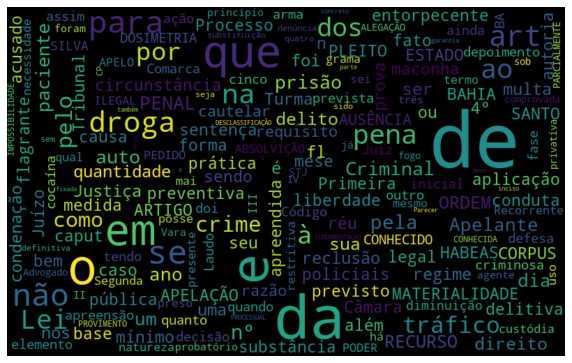

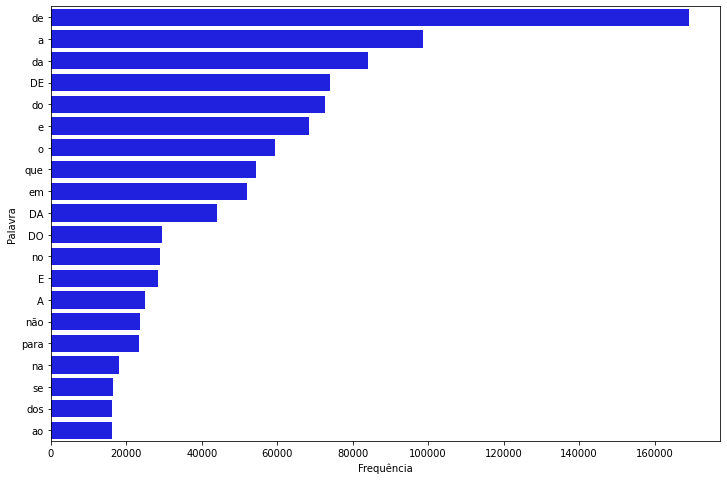

In [ ]:
# Nuvem de palavras
grafs(df_casos.texto, 20)

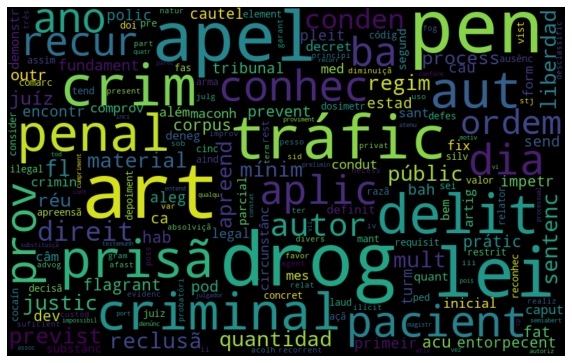

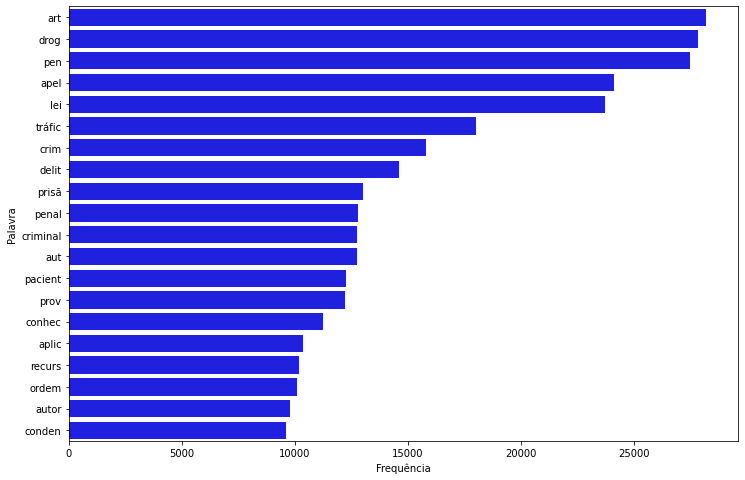

In [ ]:
# Nuvem de tokens
grafs(df_casos.tokens, 20)

In [ ]:
# Comparando o 1o texto com os outros,  sem tokenizar
df_sim = comparar(df_casos.texto, df_casos.texto[0])
df_sim

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


,semelhanca
0,1.000000
264,0.372619
430,0.340484
1159,0.224407
1821,0.200233
...,...
1814,0.002512
2125,0.002479
4886,0.002390
3058,0.002097


In [ ]:
# Comparando o 1o texto com os outros, tokenizando
df_simk = comparar(df_casos.tokens, df_casos.tokens[0])
df_simk

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


,semelhanca
0,1.000000
264,0.436193
430,0.326953
2335,0.290159
952,0.280753
...,...
763,0.004545
5017,0.004299
1020,0.004115
2000,0.003642


Texto de comparação:

In [ ]:
tagtexto(df_casos, df_sim, df_simk, 0)

100.0% de semelhança sem tokenizar.
100.0% de semelhança tokenizando.

[Habeas Corpus]
----------------------------------------


Melhores resultados:

In [ ]:
tagtexto(df_casos, df_sim, df_simk, 264)

37.26% de semelhança sem tokenizar.
43.62% de semelhança tokenizando.

[Habeas Corpus]
----------------------------------------


In [ ]:
tagtexto(df_casos, df_sim, df_simk, 430)

34.05% de semelhança sem tokenizar.
32.7% de semelhança tokenizando.

[Habeas Corpus]
----------------------------------------


## Estupro

In [ ]:
# Abrindo  os dados:
classes = []
textos = []

with open(r'tjba_casos_estupro.txt', 'r') as fp:
  classe = True
  for line in fp:
    if classe:
      classes.append(line[:-1])
      classe = False
    else:
      textos.append(line[:-1])
      classe = True

df_casos_1 = pd.DataFrame(list(zip(classes, textos)), columns = ['classe', 'texto'])
df_casos_1

,classe,texto
0,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
1,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
2,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
3,Agravo de Execução Penal,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
4,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
...,...,...
3792,Recurso Inominado,PROCESSO Nº 0166683-29.2011.8.05.0001 (nº anti...
3793,Recurso Inominado,5ª TURMA RECURSAL DOS JUIZADOS ESPECIAIS CÍVEI...
3794,Recurso Inominado,Tribunal de Justiça do Estado da Bahia PODER...
3795,Recurso Inominado,Tribunal de Justiça do Estado da Bahia PODER...


In [ ]:
# Removendo duplicatas:
dup = df_casos_1.duplicated(keep='first', subset=['texto'])
df_casos_1 = df_casos_1[~dup].reset_index(drop=True)
df_casos_1

,classe,texto
0,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
1,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
2,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
3,Agravo de Execução Penal,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
4,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...
...,...,...
3552,Recurso Inominado,5ª TURMA RECURSAL DOS JUIZADOS ESPECIAIS CÍVEI...
3553,Recurso Inominado,PROCESSO Nº 0166683-29.2011.8.05.0001 (nº anti...
3554,Recurso Inominado,5ª TURMA RECURSAL DOS JUIZADOS ESPECIAIS CÍVEI...
3555,Recurso Inominado,Tribunal de Justiça do Estado da Bahia PODER...


In [ ]:
# Tokenizando com o NLTK
t_casos = tokenizar(df_casos_1.texto)
df_casos_1['tokens'] = t_casos
df_casos_1

,classe,texto,tokens
0,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
1,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
2,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
3,Agravo de Execução Penal,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
4,Apelação,PODER JUDICIÁRIO TRIBUNAL DE JUSTIÇA DO ESTAD...,pod judiciári tribunal justic estad bah segund...
...,...,...,...
3552,Recurso Inominado,5ª TURMA RECURSAL DOS JUIZADOS ESPECIAIS CÍVEI...,turm recursal juiz espec cív crimin bah proces...
3553,Recurso Inominado,PROCESSO Nº 0166683-29.2011.8.05.0001 (nº anti...,process antig turm recursal juiz espec recurs ...
3554,Recurso Inominado,5ª TURMA RECURSAL DOS JUIZADOS ESPECIAIS CÍVEI...,turm recursal juiz espec cív crimin bah proces...
3555,Recurso Inominado,Tribunal de Justiça do Estado da Bahia PODER...,tribunal justic estad bah pod judiciári segund...


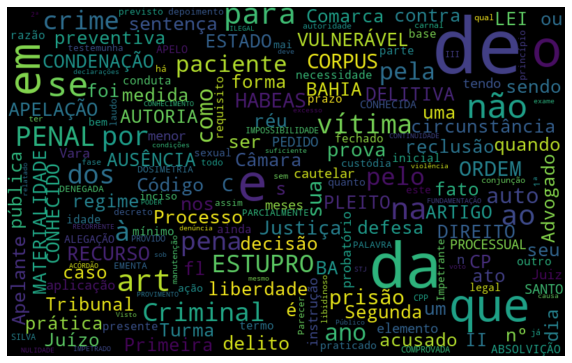

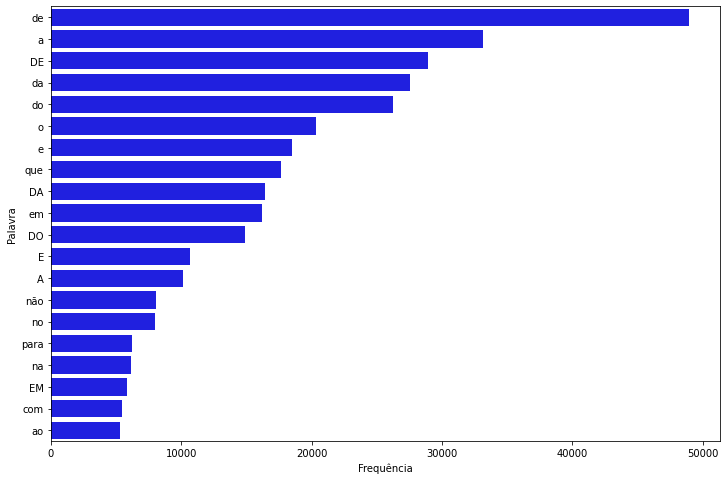

In [ ]:
# Nuvem de palavras
grafs(df_casos_1.texto, 20)

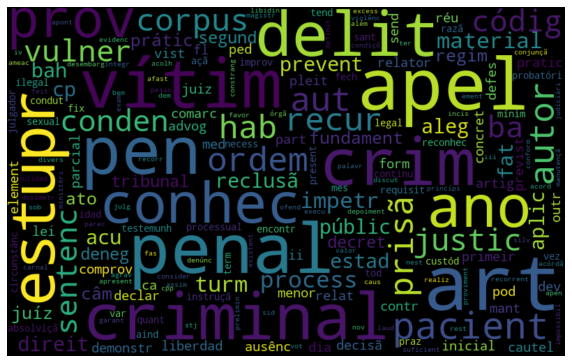

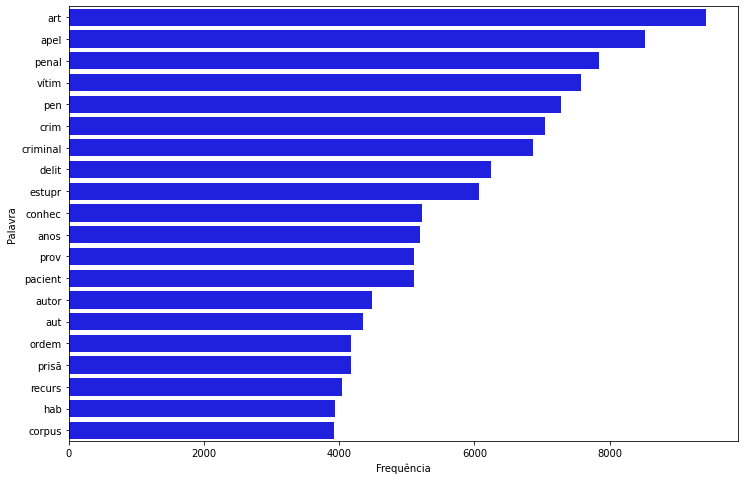

In [ ]:
# Nuvem de tokens
grafs(df_casos_1.tokens, 20)

In [ ]:
# Comparando o 1o texto com os outros, sem tokenizar
df_sim_1 = comparar(df_casos_1.texto, df_casos_1.texto[0])
df_sim_1

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


,semelhanca
0,1.000000
2,0.172685
32,0.171161
113,0.166052
553,0.165399
...,...
1995,0.000638
2184,0.000607
3216,0.000423
2113,0.000239


In [ ]:
# Comparando o 1o texto com os outros, tokenizando
df_simk_1 = comparar(df_casos_1.tokens, df_casos_1.tokens[0])
df_simk_1

/usr/local/lib/python3.8/dist-packages/gensim/similarities/docsim.py:518: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.hstack(shard_results)


,semelhanca
0,1.000000
2,0.231685
81,0.228347
1347,0.215726
236,0.214889
...,...
3270,0.001472
3250,0.001413
2040,0.001153
1877,0.001047


Texto de comparação:

In [ ]:
tagtexto(df_casos_1, df_sim_1, df_simk_1, 0)

100.0% de semelhança sem tokenizar.
100.0% de semelhança tokenizando.

[Apelação]
----------------------------------------


Melhores resultados:

In [ ]:
tagtexto(df_casos_1, df_sim_1, df_simk_1, 2)

17.27% de semelhança sem tokenizar.
23.17% de semelhança tokenizando.

[Apelação]
----------------------------------------


In [ ]:
tagtexto(df_casos_1, df_sim_1, df_simk_1, 32)

17.12% de semelhança sem tokenizar.
15.85% de semelhança tokenizando.

[Apelação]
----------------------------------------


In [ ]:
tagtexto(df_casos, df_sim, df_simk, 81)

10.85% de semelhança sem tokenizar.
8.29% de semelhança tokenizando.

[Apelação]
----------------------------------------
